Purpose: Run *k*-means clustering on mean log2 fold change of each gene in each stress.<br>
Note, this is probably a development notebook.<br>
Author: Anna Pardo<br>
Date initiated: June 30, 2023

### Part 1: Data wrangling

In [1]:
# import modules
import pandas as pd

In [2]:
# load the log fold change dataframes
## note, for k-means I am using the log fold change based on mean TPM (at least for now)
cold = pd.read_csv("../data/log2FoldChange_Cold_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])
heat = pd.read_csv("../data/log2FoldChange_Heat_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])
ln = pd.read_csv("../data/log2FoldChange_Low_Nitrogen_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])
drought = pd.read_csv("../data/log2FoldChange_Drought_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])
salt = pd.read_csv("../data/log2FoldChange_Salt_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])
flood = pd.read_csv("../data/log2FoldChange_Flooding_meanTPM.tsv",sep="\t",header="infer",usecols=["GeneID","log2FoldChange"])

In [3]:
flood.head()

,GeneID,log2FoldChange
0,Zm00001eb000010,-0.562755
1,Zm00001eb000020,0.549133
2,Zm00001eb000050,0.082415
3,Zm00001eb000060,0.234120
4,Zm00001eb000070,0.153657


In [4]:
# rename the log fold change column for each df prior to merging
cold.rename(columns={"log2FoldChange":"lfc_Cold"},inplace=True)
heat.rename(columns={"log2FoldChange":"lfc_Heat"},inplace=True)
ln.rename(columns={"log2FoldChange":"lfc_Low_Nitrogen"},inplace=True)
drought.rename(columns={"log2FoldChange":"lfc_Drought"},inplace=True)
salt.rename(columns={"log2FoldChange":"lfc_Salt"},inplace=True)
flood.rename(columns={"log2FoldChange":"lfc_Flooding"},inplace=True)

In [5]:
flood.head()

,GeneID,lfc_Flooding
0,Zm00001eb000010,-0.562755
1,Zm00001eb000020,0.549133
2,Zm00001eb000050,0.082415
3,Zm00001eb000060,0.234120
4,Zm00001eb000070,0.153657


In [6]:
# merge all on GeneID column
lfcall = cold.merge(heat.merge(ln.merge(drought.merge(salt.merge(flood)))))
lfcall.head()

,GeneID,lfc_Cold,lfc_Heat,lfc_Low_Nitrogen,lfc_Drought,lfc_Salt,lfc_Flooding
0,Zm00001eb000010,-0.391583,-0.106852,0.212826,0.345492,-0.209462,-0.562755
1,Zm00001eb000020,0.106499,0.320077,0.090038,-0.444721,-0.175740,0.549133
2,Zm00001eb000050,-0.040985,0.633388,0.037542,0.031965,-0.106674,0.082415
3,Zm00001eb000060,-0.299335,-0.232392,0.578955,0.063305,-0.157965,0.234120
4,Zm00001eb000070,-0.086644,0.077571,0.015118,0.432822,-0.626413,0.153657


In [7]:
len(lfcall.index)==len(lfcall.dropna(axis=0).index)

True

### Part 2: Make a preliminary plot
Following https://towardsdatascience.com/clustering-electricity-profiles-with-k-means-42d6d0644d00

In [8]:
import matplotlib.pyplot as plt

In [9]:
lfcall.set_index("GeneID",inplace=True)
lfcall.head()

,lfc_Cold,lfc_Heat,lfc_Low_Nitrogen,lfc_Drought,lfc_Salt,lfc_Flooding
GeneID,,,,,,
Zm00001eb000010,-0.391583,-0.106852,0.212826,0.345492,-0.209462,-0.562755
Zm00001eb000020,0.106499,0.320077,0.090038,-0.444721,-0.175740,0.549133
Zm00001eb000050,-0.040985,0.633388,0.037542,0.031965,-0.106674,0.082415
Zm00001eb000060,-0.299335,-0.232392,0.578955,0.063305,-0.157965,0.234120
Zm00001eb000070,-0.086644,0.077571,0.015118,0.432822,-0.626413,0.153657


<AxesSubplot: xlabel='GeneID'>

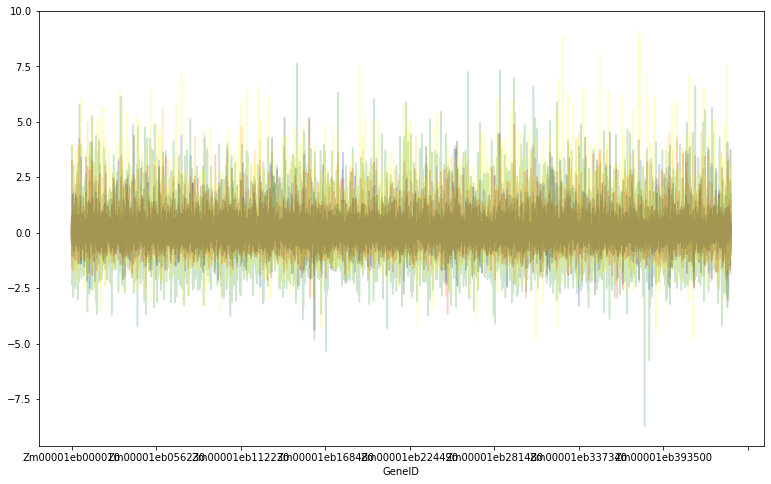

In [10]:
lfcall["lfc_Cold"].plot(figsize=(13,8),legend=False,color="blue",alpha=0.2)
lfcall["lfc_Heat"].plot(figsize=(13,8),legend=False,color="orange",alpha=0.2)
lfcall["lfc_Drought"].plot(figsize=(13,8),legend=False,color="red",alpha=0.2)
lfcall["lfc_Low_Nitrogen"].plot(figsize=(13,8),legend=False,color="black",alpha=0.2)
lfcall["lfc_Salt"].plot(figsize=(13,8),legend=False,color="green",alpha=0.2)
lfcall["lfc_Flooding"].plot(figsize=(13,8),legend=False,color="yellow",alpha=0.2)

### Part 3: Optimization of *k* using silhouette score

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import numpy as np

In [12]:
# examine silhouette scores of n=2-30 clusters to pick the best n
sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

X = lfcall.values.copy()
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

In [13]:
type(n_cluster_list)

numpy.ndarray

In [14]:
# bind into a dataframe
ncsil = pd.DataFrame(list(zip(list(n_cluster_list),sillhoute_scores)),columns=["Number of clusters","Average silhouette score"])

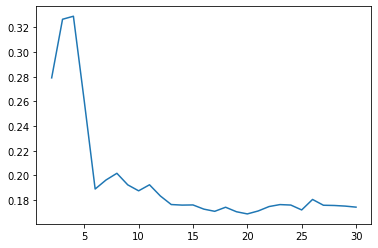

In [15]:
# plot
plt.plot(ncsil["Number of clusters"],ncsil["Average silhouette score"])

According to the silhouette score method, the optimal number of clusters is 5.

### Part 4: Optimization of *k* using elbow method
From https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [16]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

In [17]:
X = lfcall.values.copy()

In [18]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 31)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/leviathan2

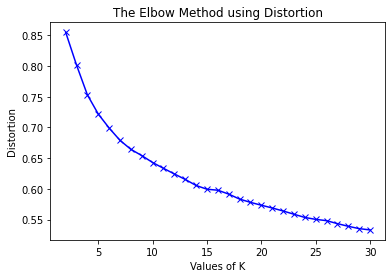

In [19]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

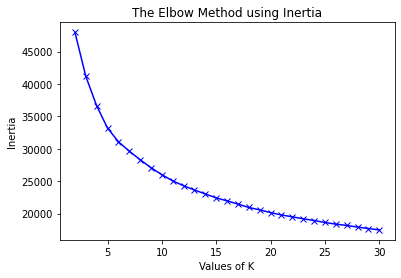

In [20]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

According to the elbow method, the optimal number of clusters is the point on the graph after which the slope is linear. Using inertia, this seems to be somewhere around 10-11. Using distortion, this appears to be either 14 or ~8. I find this method more difficult to interpret than the silhouette method.

### Part 5: Do a *k*-means clustering with *k*=4

In [21]:
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
lfcall_kmeans = lfcall.set_index(cluster_found_sr, append=True )

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
color_list = ['blue','red','green','orange']

In [23]:
cluster_values = sorted(lfcall_kmeans.index.get_level_values('cluster').unique())

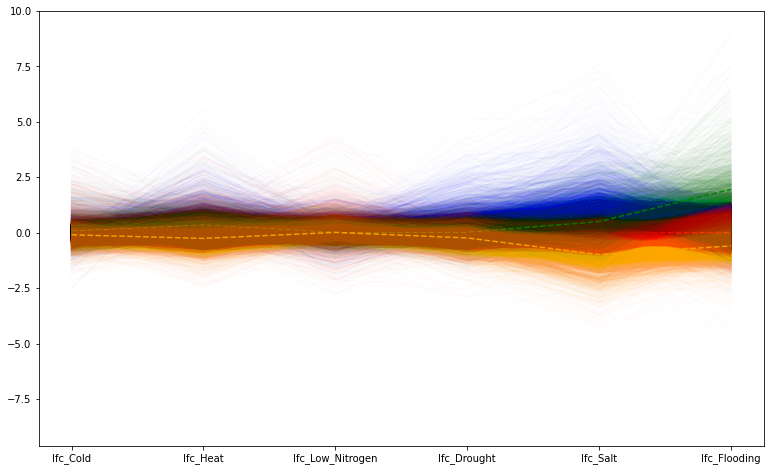

In [24]:
fig,ax = plt.subplots(1,1,figsize=(13,8))
for cluster, color in zip(cluster_values, color_list):
    lfcall_kmeans.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    lfcall_kmeans.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

It's hard to draw conclusions from this.

### Part 6: What genes are in each cluster?

In [25]:
lfcall_kmeans.head()

,,lfc_Cold,lfc_Heat,lfc_Low_Nitrogen,lfc_Drought,lfc_Salt,lfc_Flooding
GeneID,cluster,,,,,,
Zm00001eb000010,1,-0.391583,-0.106852,0.212826,0.345492,-0.209462,-0.562755
Zm00001eb000020,1,0.106499,0.320077,0.090038,-0.444721,-0.175740,0.549133
Zm00001eb000050,1,-0.040985,0.633388,0.037542,0.031965,-0.106674,0.082415
Zm00001eb000060,1,-0.299335,-0.232392,0.578955,0.063305,-0.157965,0.234120
Zm00001eb000070,1,-0.086644,0.077571,0.015118,0.432822,-0.626413,0.153657


In [26]:
# pop out the indices
lfcall_kmeans.reset_index(inplace=True)

In [27]:
lfcall_kmeans.head()

,GeneID,cluster,lfc_Cold,lfc_Heat,lfc_Low_Nitrogen,lfc_Drought,lfc_Salt,lfc_Flooding
0,Zm00001eb000010,1,-0.391583,-0.106852,0.212826,0.345492,-0.209462,-0.562755
1,Zm00001eb000020,1,0.106499,0.320077,0.090038,-0.444721,-0.175740,0.549133
2,Zm00001eb000050,1,-0.040985,0.633388,0.037542,0.031965,-0.106674,0.082415
3,Zm00001eb000060,1,-0.299335,-0.232392,0.578955,0.063305,-0.157965,0.234120
4,Zm00001eb000070,1,-0.086644,0.077571,0.015118,0.432822,-0.626413,0.153657


In [28]:
lfcall_kmeans["cluster"].unique()

array([1, 0, 3, 2])

In [29]:
# separate into dataframes for each of the 4 clusters
c1 = lfcall_kmeans[lfcall_kmeans["cluster"]==0].drop("cluster",axis=1).rename(columns={"lfc_Cold":"Cold",
                                                                                      "lfc_Heat":"Heat",
                                                                                      "lfc_Low_Nitrogen":"Low N",
                                                                                      "lfc_Drought":"Drought",
                                                                                      "lfc_Salt":"Salt",
                                                                                      "lfc_Flooding":"Flooding"})
c2 = lfcall_kmeans[lfcall_kmeans["cluster"]==1].drop("cluster",axis=1).rename(columns={"lfc_Cold":"Cold",
                                                                                      "lfc_Heat":"Heat",
                                                                                      "lfc_Low_Nitrogen":"Low N",
                                                                                      "lfc_Drought":"Drought",
                                                                                      "lfc_Salt":"Salt",
                                                                                      "lfc_Flooding":"Flooding"})
c3 = lfcall_kmeans[lfcall_kmeans["cluster"]==2].drop("cluster",axis=1).rename(columns={"lfc_Cold":"Cold",
                                                                                      "lfc_Heat":"Heat",
                                                                                      "lfc_Low_Nitrogen":"Low N",
                                                                                      "lfc_Drought":"Drought",
                                                                                      "lfc_Salt":"Salt",
                                                                                      "lfc_Flooding":"Flooding"})
c4 = lfcall_kmeans[lfcall_kmeans["cluster"]==3].drop("cluster",axis=1).rename(columns={"lfc_Cold":"Cold",
                                                                                      "lfc_Heat":"Heat",
                                                                                      "lfc_Low_Nitrogen":"Low N",
                                                                                      "lfc_Drought":"Drought",
                                                                                      "lfc_Salt":"Salt",
                                                                                      "lfc_Flooding":"Flooding"})

In [30]:
c1.head()

,GeneID,Cold,Heat,Low N,Drought,Salt,Flooding
9,Zm00001eb000140,0.087437,0.029586,0.003740,0.005781,1.550271,-0.690377
13,Zm00001eb000190,0.118549,0.567773,0.013349,0.123619,0.637036,0.180963
14,Zm00001eb000200,0.175023,0.059561,0.091949,3.266229,3.918920,0.158127
19,Zm00001eb000250,-0.020745,0.198687,-0.108102,0.166714,0.815193,0.167324
24,Zm00001eb000320,0.069439,0.322918,-0.119078,0.365124,0.772172,0.320626


In [31]:
# how many genes are in each cluster?
print("Number of genes in cluster 1: ",len(c1.index))
print("Number of genes in cluster 2: ",len(c2.index))
print("Number of genes in cluster 3: ",len(c3.index))
print("Number of genes in cluster 4: ",len(c4.index))

Number of genes in cluster 1:  8706
Number of genes in cluster 2:  24532
Number of genes in cluster 3:  1637
Number of genes in cluster 4:  4129


In [32]:
c1t = c1.set_index("GeneID").transpose().reset_index().rename(columns={"index":"Stressor"})
c2t = c2.set_index("GeneID").transpose().reset_index().rename(columns={"index":"Stressor"})
c3t = c3.set_index("GeneID").transpose().reset_index().rename(columns={"index":"Stressor"})
c4t = c4.set_index("GeneID").transpose().reset_index().rename(columns={"index":"Stressor"})

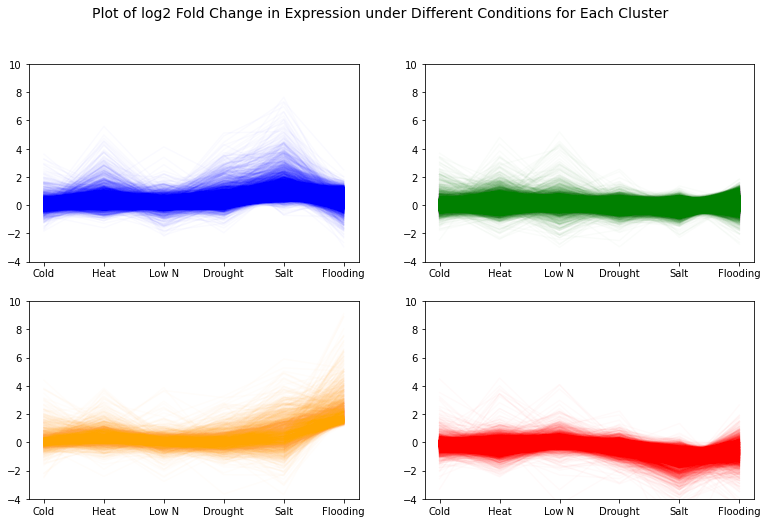

In [33]:
# plot each cluster separately
fig,ax = plt.subplots(2,2,figsize=(13,8))
for gene in c1t.columns:
    if gene != "Stressor":
        ax[0,0].plot(c1t["Stressor"],c1t[gene],color="blue",alpha=0.02)
        ax[0,0].set_ylim(-4,10)
for gene in c2t.columns:
    if gene != "Stressor":
        ax[0,1].plot(c2t["Stressor"],c2t[gene],color="green",alpha=0.02)
        ax[0,1].set_ylim(-4,10)
for gene in c3t.columns:
    if gene != "Stressor":
        ax[1,0].plot(c3t["Stressor"],c3t[gene],color="orange",alpha=0.02)
        ax[1,0].set_ylim(-4,10)
for gene in c4t.columns:
    if gene != "Stressor":
        ax[1,1].plot(c4t["Stressor"],c4t[gene],color="red",alpha=0.02)
        ax[1,1].set_ylim(-4,10)
plt.suptitle("Plot of log2 Fold Change in Expression under Different Conditions for Each Cluster",fontsize=14)
#plt.savefig("../figures/kmeans_k4_lfcplot_clusters.png?")
plt.show()